In [12]:
import cv2 as cv
import albumentations as A
import os
import sys
import datetime
import io

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Input,
    BatchNormalization,
    Layer,
    InputLayer,
    Dropout,
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    TopKCategoricalAccuracy,
)
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

# from google.colab import drive
# drive.mount('/content/drive')
# TRAIN_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/train"
# TEST_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/test"

TRAIN_DIR = "./datasets/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "./datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]  # This needs to be in accord with dir names.

CONFIG = {
    "batch_size": 32,
    "im_shape": (256, 256),
    "im_size": 256,
    "input_shape": (None, None, 3),
    "filters_1": 6,
    "filters_2": 16,
    "kernel_size": 3,
    "activation_1": "relu",
    "activation_2": "softmax",
    "dropout": 0.01,
    # "dropout": 0.00,
    "regularization_l2": 0.1,
    # "regularization_l2": 0.0,
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "pool_size": 2,
    "strides_1": 1,
    "strides_2": 2,
    "dense_1": 32,
    "dense_2": 32,
    "dense_3": 32,
    "dense_out": 3,
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 25,
}

In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    # NOTE: int -> 0 | 1 | 2; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [14]:
backbone = tf.keras.applications.EfficientNetB5(
    include_top=False, # We don't want the Classifier part, only the Feature Extractor part.
    weights="imagenet",
    input_shape=(CONFIG["im_size"], CONFIG["im_size"], 3),
)
backbone.trainable = False

1. `pretrained_model` contains the whole model (feature extractor part and classifier part).
2. `last_conv_layer_model` contains the inputs from `pretrained_model` and outputs from `top_activation` layer. Those outputs are the feature maps.
3. `classifier_model` contains the classification layers except for the BatchNormalization layer.

In [15]:
inputs = backbone.inputs
# This way expands the layers of the backbone to the new model we're creating, 
# so we can extract each layer individually when necessary.
x = backbone.output 
# x = backbone(input) 

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(len(CLASS_NAMES), activation="softmax")(x)

pretrained_model = Model(inputs, outputs)
pretrained_model.summary()
# pretrained_model.load_weights("transfer_learning.weights.h5")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      1,152 │ block1a_se_excit

 Total params: 30,747,386 (117.29 MB)

 Trainable params: 2,231,811 (8.51 MB)

 Non-trainable params: 28,515,575 (108.78 MB)

In [ ]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "transfer_learning.weights.h5",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    initial_value_threshold=None,
)

pretrained_model.compile(
    optimizer=Adam(learning_rate=CONFIG["learning_rate"]*10),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=metrics,
)

history = pretrained_model.fit(
    train_dataset.take(10), # Simulating small dataset (for thats the purpose of transfer learning)
    validation_data=test_dataset,
    epochs=CONFIG["epochs"],
    verbose=1,
    callbacks=[model_checkpoint],
)

In [19]:
pretrained_model.load_weights("transfer_learning.weights.h5")

In [20]:
inputs = pretrained_model.inputs

last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
outputs = last_conv_layer.output

last_conv_layer_model = Model(inputs, outputs)
last_conv_layer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      1,152 │ block1a_se_excit

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,513,527 (108.77 MB)

In [23]:
classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_3",
    # skipping batch_normalization layer
    "dense_4",
    "dense_5",
]

# This shape is the output shape of top_activation layer (which is the last conv layer)
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
    x = pretrained_model.get_layer(layer_name)(x)
    
classifier_model = Model(classifier_input, x)
classifier_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 8, 8, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,229,763 (8.51 MB)

 Trainable params: 2,229,763 (8.51 MB)

 Non-trainable params: 0 (0.00 B)

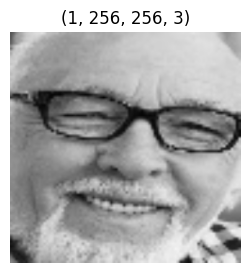

In [24]:
img = cv.imread("./datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
img = cv.resize(img, (256, 256))
img = tf.constant(img, dtype=tf.float32)
img = tf.expand_dims(img, axis=0)

plt.figure(figsize=[3,3])
plt.imshow(img[0]/255.0)
plt.title(img.shape)
plt.axis("off")
plt.show()

In [25]:
with tf.GradientTape() as tape:
    feature_maps = last_conv_layer_model(img)
    # Score for each class (angry, happy, sad).
    scores = classifier_model(feature_maps)
    score_idx = tf.math.argmax(scores[0])
    # the `:` is just because `score` has shape (1, 3). Ex: [[1.4e-9, 5.2e-3, 4.1e-1]]
    top_score = scores[:, score_idx]
    
# Computing the derivative of the output of the classifier_model (scores[:, score_idx]) 
# with respect to the feature_maps (output of the last_conv_layer_model).
grads = tape.gradient(top_score, feature_maps)
grads.shape

TensorShape([1, 8, 8, 2048])

In [26]:
# Calculating the mean of each channel separately. 
# axis=(0,1,2) -> freeze the first three dimensions and calculate the mean of each channel (last dimension) among them.
# NOTE: remember that `grads` is technically another feature map with the same rank of the `feature_maps` variable.
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

feature_maps_by_means = feature_maps.numpy()[0]
# feature_maps.shape[-1] == 2048 (channel size)
for i in range(feature_maps.shape[-1]):
    # Multiplying each element of each channel by it's corresponding mean.
    feature_maps_by_means[:, :, i] *= pooled_grads[i]

# Summing all values of the feature maps for each position across all channels 
# (this will generate feature map with one channel because we're summing all of them).
fm_channel_sum = np.sum(feature_maps_by_means, axis=-1)
heatmap = tf.nn.relu(fm_channel_sum)

print(pooled_grads.shape)
print(fm_channel_sum.shape)

(2048,)
(8, 8)


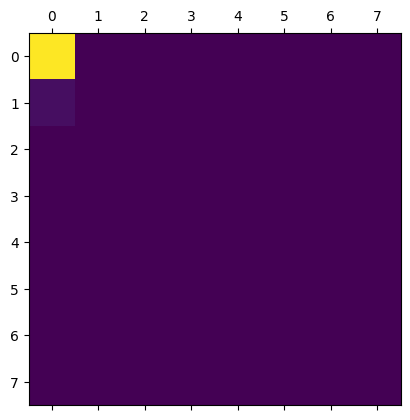

In [27]:
plt.matshow(heatmap)
plt.show()

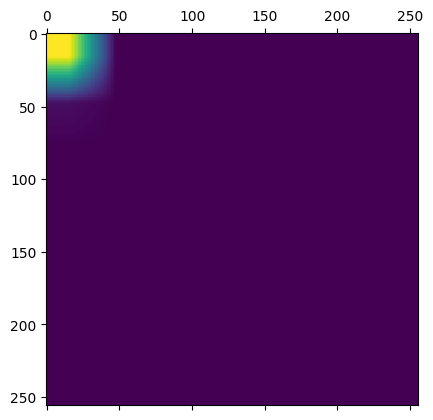

In [28]:
plt.matshow(cv.resize(heatmap.numpy(), (256, 256)))
plt.show()